# Semivariogram models

## Table of Contents:

1. Create random surface,
2. Create the experimental variogram,
3. Set all variogram models,
4. Compare variogram models.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2022-08-16 | The first release of tutorial | @SimonMolinsky |

## Introduction

`Pyinterpolate` allows us to use multiple variogram models for your analysis. All of them are derived from a literature. In this tutorial, we will compare those models on an artificial surface. We will learn:

- how to create artificial surface with Python,
- what variogram models are available for us,
- what are the differences between variogram models.

## Import packages

In [1]:
from scipy.signal import convolve2d
from scipy.sparse import coo_matrix

from pyinterpolate.variogram import build_experimental_variogram
from pyinterpolate.variogram.theoretical.models import *

import matplotlib.pyplot as plt

## 1) Create random surface

In the first step, we will create the artificial surface. The reason why we choose an artificial object instead of real-world observations is that we have more control over variogram parameters. We want to compare different models, thus we should limit number of unknowns of our dataset to a bare minimum. But don't be disappointed! Our surface won't be *boring* because we will generate it from an interesting function named [`logistic_map`](https://en.wikipedia.org/wiki/Logistic_map). It is polynomial mapping that, for some parameters, presents chaotic behavior.

**Logistic map** is a recurrent relation of the form:

$$x_{n+1} = rx_{n}(1-x_{n}),$$

where:
- $x$: is a mapped value at a step $n$ or $n+1$, its state depends only on the previous step and initial set of parameters, $x \in [0, 1]$.
- $r$: is a special parameter and its value leads to a different behavior of a system. For us, the most important is a set of possible $r$ values within limits $[3.5, 4]$ where system has chaotic behavior [more](https://en.wikipedia.org/wiki/Logistic_map#Behavior_dependent_on_r).

We will use `generate_logistic_map` function that takes 3 parameters:

- `r`: the same as $r$ from the **logistic map** system, we set it to **3.9**.
- `size`: the length of generated sequence, it should be resonably large to create a surface, we set it to **10k**.
- `initial_ratio`: initial `x` value between 0 and 1. We set it to **0.33**.

In [2]:
# Create logistic map

def generate_logistic_map(r: float, size: int, initial_ratio: float) -> np.array:
    # rxn(1-xn)
    vals = [initial_ratio]
    for _ in range(size-1):
        new_val = r * vals[-1] * (1 - vals[-1])
        vals.append(new_val)
    return np.array(vals)

In [3]:
values = generate_logistic_map(3.9, 10000, 0.33)

At this point, our data is a **1-D** array and we can represent it as a signal:

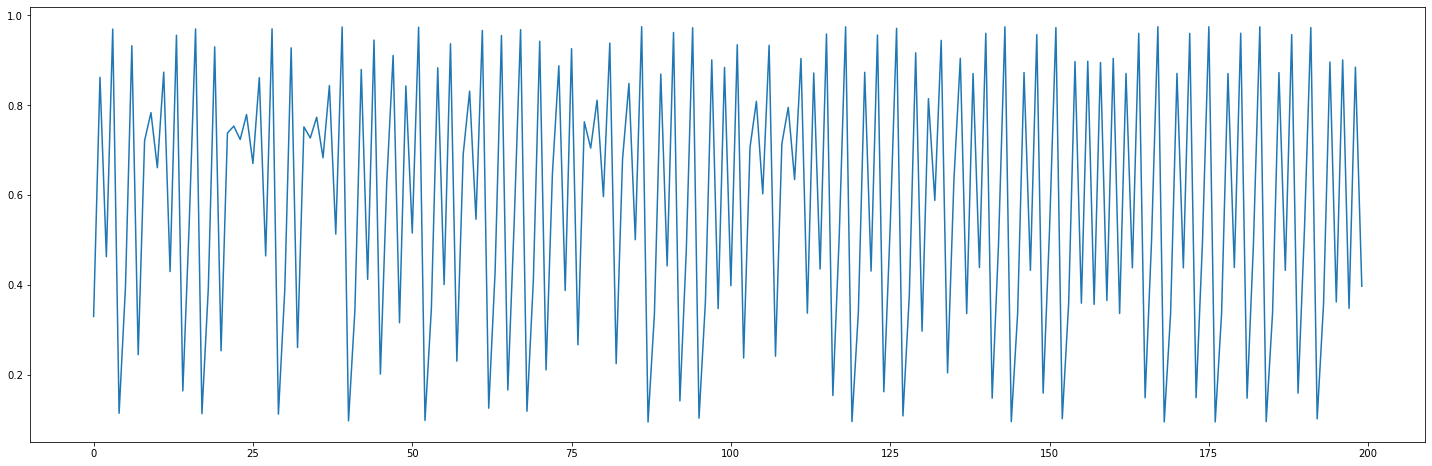

In [4]:
plt.figure(figsize=(25, 8))
plt.plot(values[0:200])
plt.show()

Let's reshape this signal into a **2-D** matrix:

In [5]:
# Create surface from array

surface = np.reshape(values, (100, 100))

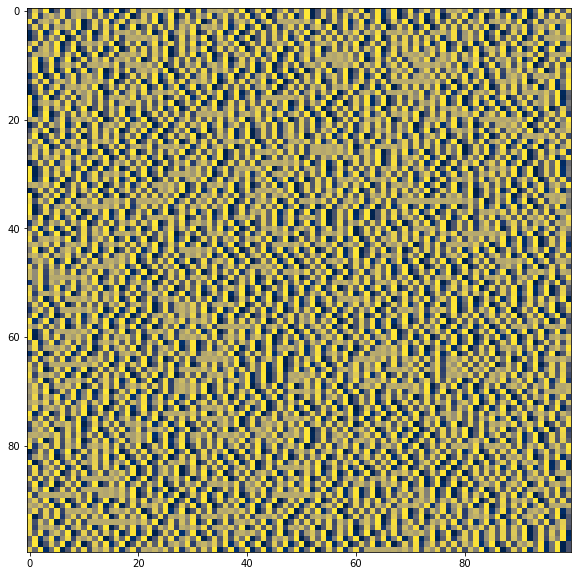

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(surface, cmap='cividis')
plt.show()

The spatial correlation of this structure is very weak, we can change it with a simple blur filter. It's size will be our **range** parameter!

In [7]:
# Slightly blur image with simple mean filter

mean_filter = np.ones(shape=(7, 7))

surf_blurred = convolve2d(surface, mean_filter, boundary='wrap')

And here we are! We have our artificial surface for testing purposes!

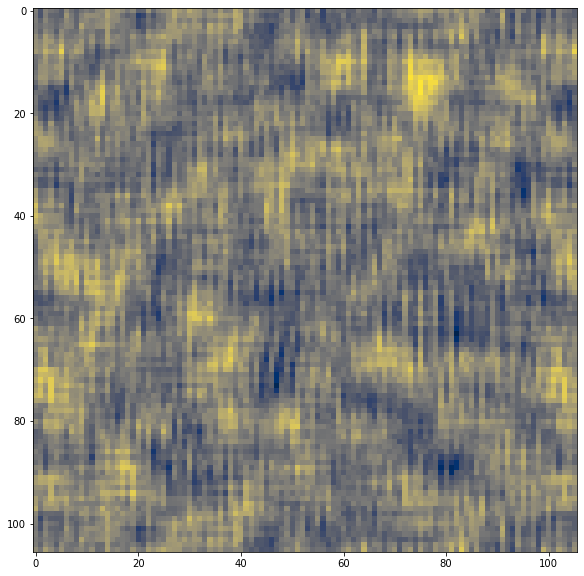

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(surf_blurred, cmap='cividis')
plt.show()

## 2) Create the experimental variogram

We must create the experimental variogram before we start comparing theoretical models. For this our 2-D surface must be presented as an array:

```
[[coordinate x1, coordinate y1, value1],
 [coordinate x2, coordinate y2, value2],
 [...],]
```

We will transform our 2-D surface into an array with coordinates (pixel coordinates) with `scipy` and `numpy`:


In [9]:
# Transform data into x, y, val array

In [10]:
sparse_data = coo_matrix(surf_blurred)

In [11]:
# data, col, row == value, x, y

In [12]:
xyval = np.asarray([sparse_data.col, sparse_data.row, sparse_data.data]).T

We know our data - the effective range of correlation is 7 steps, we have set mean filter into this size. With this knowledge, we will set `step_size` into 2 units and `max_range` into 20 (way above the real maximum range, that is 7, but we show in this way how variograms behave at a large distance).

In [13]:
# Get experimental variogram

In [14]:
experimental = build_experimental_variogram(xyval, 2, 20)

In [15]:
semivars = experimental.experimental_semivariance_array.copy()

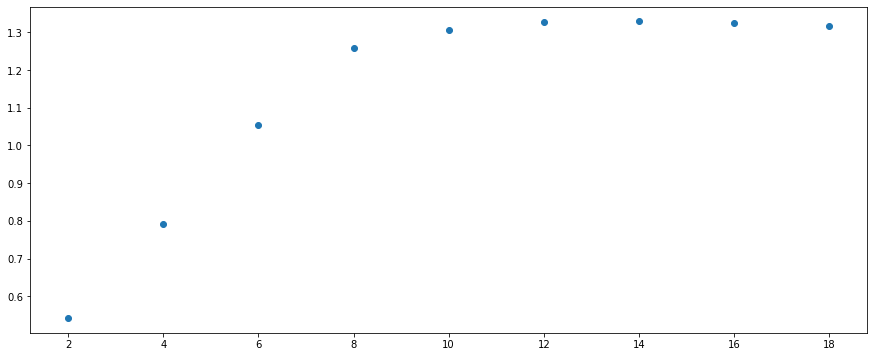

In [16]:
plt.figure(figsize=(15, 6))
plt.scatter(semivars[:, 0], semivars[:, 1])
plt.show()

We read a plot and decide to set:

- **nugget** to `0`,
- **sill** to `1.3`,
- **range** to `7`,
- **lags** to list of distances from 2 to 18.

Yes, we can create the theoretical variogram from scratch, without calling `build_theoretical_variogram()` function or `TheoreticalVariogram` class. Those three parameters and lags list are all what we need for modeling.

In [17]:
# Set nugget, sill and range

In [18]:
_nugget = 0
_sill = 1.3
_range = 7
_lags = semivars[:, 0].copy()

## 3) Set all variogram models

Variogram models are imported as external functions and they are not a part of any object. We can use this fact, import all models, and calculate their outputs. In this step, we will calculate seven different theoretical models and show them in comparison to the experimental variogram.

Models to calculate:

- circular,
- cubic,
- exponential,
- gaussian,
- linear,
- power,
- spherical.

In [19]:
# Crete different models: circular, cubic, exponential, gaussian, linear, power, spherical

In [20]:
circular = circular_model(lags=_lags,
                          nugget=_nugget,
                          sill=_sill,
                          rang=_range)

cubic = cubic_model(lags=_lags,
                    nugget=_nugget,
                    sill=_sill,
                    rang=_range)

exponential = exponential_model(lags=_lags,
                                nugget=_nugget,
                                sill=_sill,
                                rang=_range)

gaussian = gaussian_model(lags=_lags,
                          nugget=_nugget,
                          sill=_sill,
                          rang=_range)

linear = linear_model(lags=_lags,
                      nugget=_nugget,
                      sill=_sill,
                      rang=_range)

power = power_model(lags=_lags,
                    nugget=_nugget,
                    sill=_sill,
                    rang=_range)

spherical = spherical_model(lags=_lags,
                            nugget=_nugget,
                            sill=_sill,
                            rang=_range)

With all models calculated, let's take a look into their output. Before we jump into the last step, try to guess which model works optimally with the experimental variogram? (It is a tricky question!)

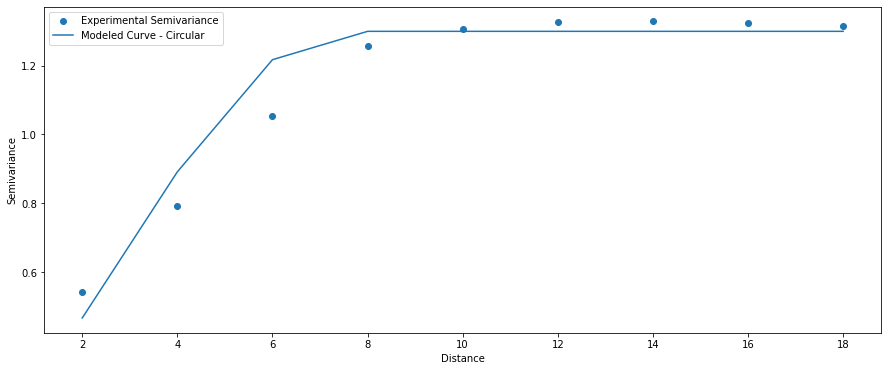

In [21]:
# Plot circular

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, circular)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Circular'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

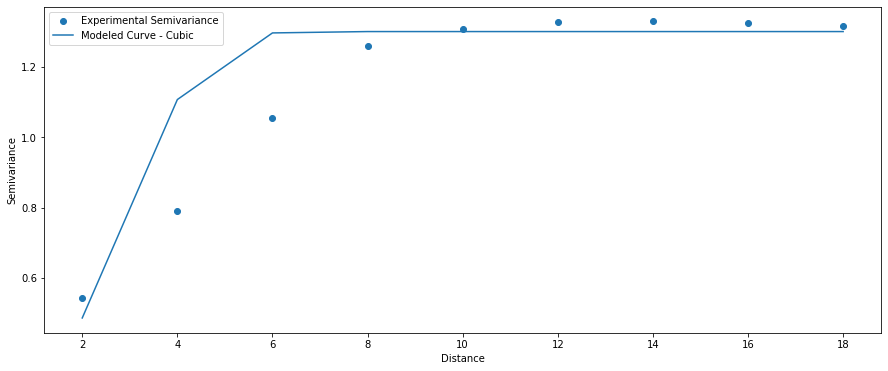

In [22]:
# Plot cubic

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, cubic)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Cubic'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

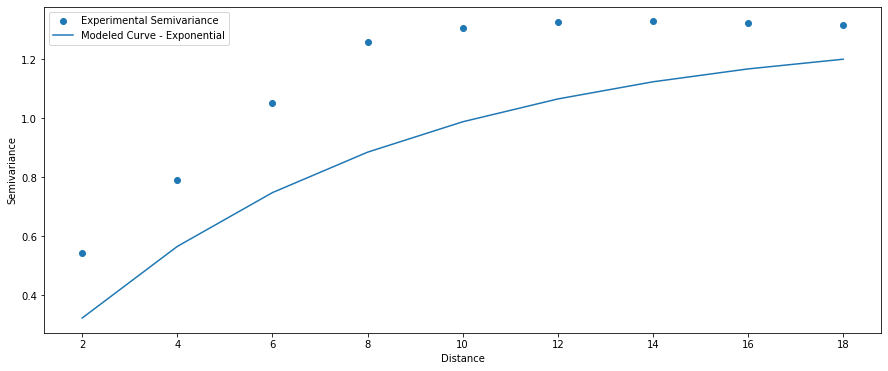

In [23]:
# Plot exponential

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, exponential)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Exponential'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

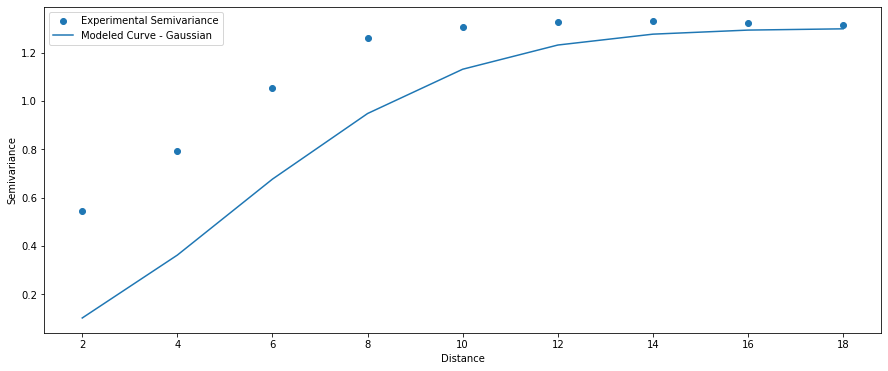

In [24]:
# Plot gaussian

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, gaussian)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Gaussian'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

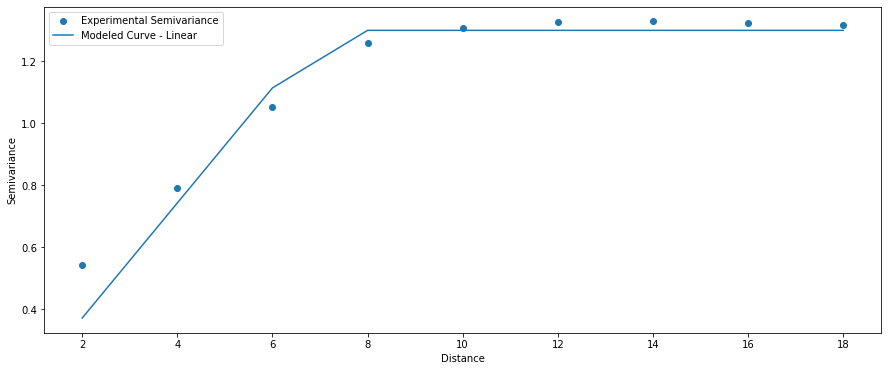

In [25]:
# Plot linear

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, linear)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Linear'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

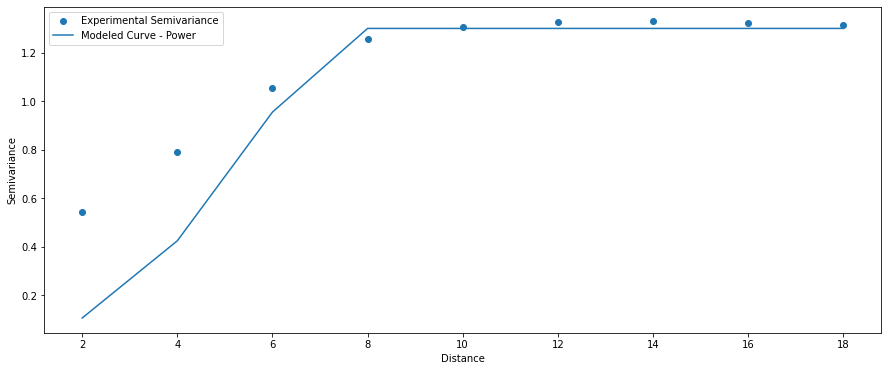

In [26]:
# Plot power

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, power)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Power'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

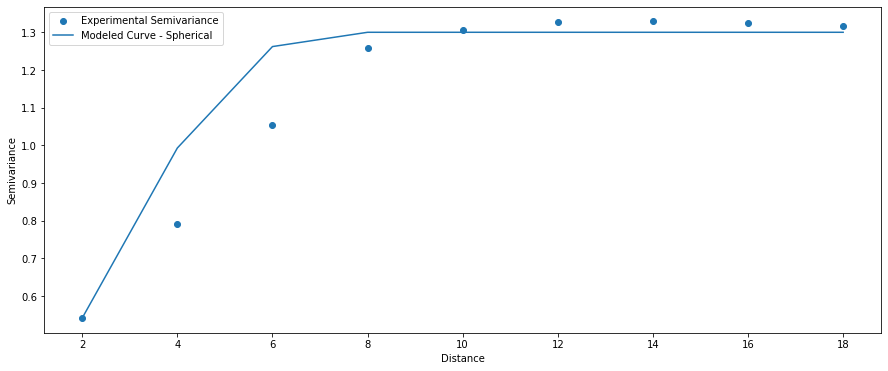

In [27]:
# Plot spherical

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, spherical)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Spherical'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

What was your guess?

.
.
.

I hope, that we both have chosen `circulcar` or `linear` models! But we should be careful with the final opinion, and even more careful if we let an algorithm to decide which model is the best based on the **root mean squared error metric** (RMSE). For us, the best model is always the model that has the best fits for closest distances. Model that has low RMSE may be "great" with distances from 10 to 18... which are oscillating around sill of our data and are useless for weighting (weight is constant from some distance).

## 4) Compare variogram models

The last part is a comparison of variogram models. We will still use our "own eyes" to decide which model is the best, but this time we will plot all of them in a single plot.

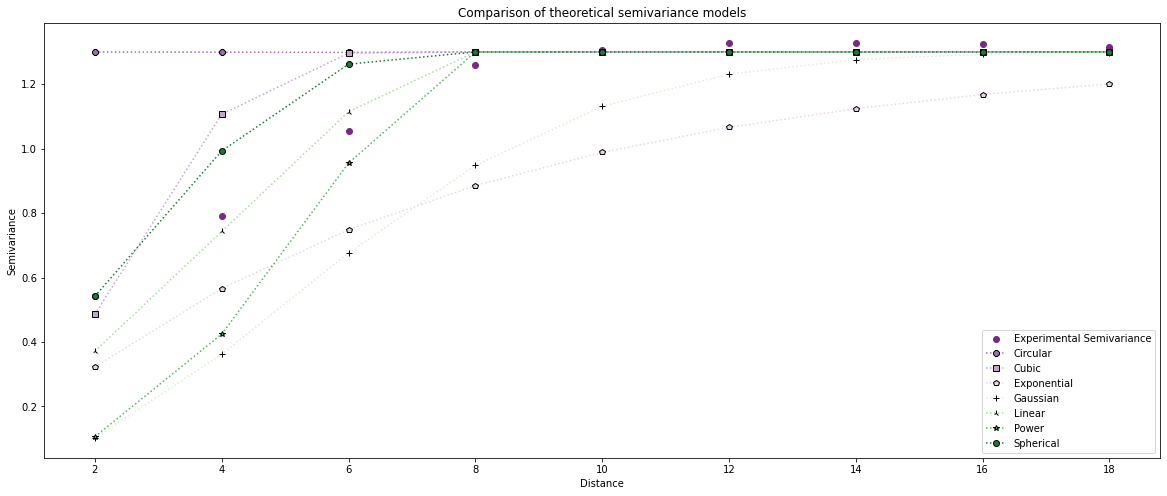

In [28]:
# Plot ALL models

plt.figure(figsize=(20, 8))
plt.scatter(_lags, semivars[:, 1], color='#762a83')
plt.plot(_lags, circular, ':8', color='#9970ab', mec='black')
plt.plot(_lags, cubic, ':s', color='#c2a5cf', mec='black')
plt.plot(_lags, exponential, ':p', color='#e7d4e8', mec='black')
plt.plot(_lags, gaussian, ':+', color='#d9f0d3', mec='black')
plt.plot(_lags, linear, ':2', color='#a6dba0', mec='black')
plt.plot(_lags, power, ':*', color='#5aae61', mec='black')
plt.plot(_lags, spherical, ':o', color='#1b7837', mec='black')
plt.title('Comparison of theoretical semivariance models')
plt.legend(['Experimental Semivariance',
            'Circular',
            'Cubic',
            'Exponential',
            'Gaussian',
            'Linear',
            'Power',
            'Spherical'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

We observe, that the lowest distance from a modeled values to the experimental curve at a small distance has...

---

## Where to go?

### Next steps:

* [Ordinary and Simple Kriging]()
* [Variogram Point Cloud]()

### More about variogram modeling:

* [Semivariogram Estimation]()

---